In [10]:
# Simple feature extraction with a pretrained model
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

def extract_features(image_path):
    # Load the image
    image = Image.open(image_path).convert('RGB')
    
    # Define the transformation
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = transform(image).unsqueeze(0)
    
    # Load a pretrained ResNet model
    model = models.resnet18(pretrained=True)
    model.eval()
    
    # Extract features
    with torch.no_grad():
        features = model(image)
    
    return features

features = extract_features('../datasets/train/Smart Phones/Image_16.jpg')
print(features)


tensor([[-7.7424e-01, -2.5864e+00, -2.4282e+00, -2.3983e+00,  1.8739e+00,
         -1.7252e+00, -2.1723e+00, -4.3411e+00, -4.7722e+00, -3.6711e+00,
         -1.9263e+00, -3.0574e+00, -9.0373e-01, -1.6118e+00, -2.9721e+00,
         -3.2667e+00, -1.8232e+00, -3.5813e+00, -2.3100e+00, -2.2663e+00,
         -5.3251e+00, -1.2458e+00, -3.2065e+00, -2.0529e+00, -4.0935e+00,
         -4.7072e+00, -2.6318e+00, -1.0418e+00, -3.0478e+00, -4.2928e+00,
         -4.3037e+00, -2.6498e+00, -1.7798e+00, -3.6337e+00, -3.7677e+00,
         -4.7231e+00, -5.0751e+00, -5.9379e+00, -1.7157e+00, -5.2081e+00,
         -4.8001e+00, -5.3226e+00, -5.1544e+00, -4.2042e+00, -4.6925e+00,
         -2.8257e+00, -5.0039e+00, -3.3206e+00, -7.1701e+00, -4.9734e+00,
         -4.1700e+00, -6.9466e-01, -3.2521e-02,  4.3366e-01, -3.4374e+00,
         -5.1045e+00, -2.4903e+00, -3.5666e+00, -3.6258e+00, -3.5957e+00,
         -9.1335e-01, -1.4305e+00, -2.4454e+00, -2.8437e-01, -5.4472e+00,
         -1.0053e+00, -3.6587e+00, -3.

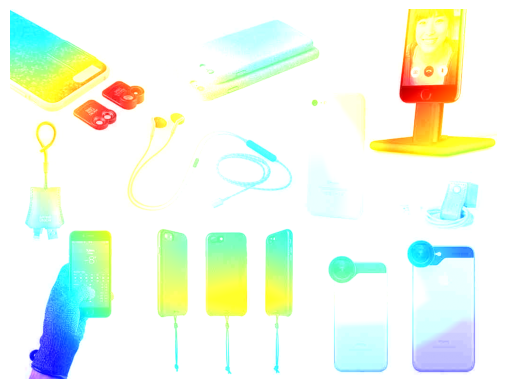

In [11]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

class CAM:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.features = []
        self.activations = []
        
        def hook_fn(module, input, output):
            self.features.append(output)
            self.activations.append(input[0])
        
        self.hook = self.model.layer4[1].register_forward_hook(hook_fn)

    def generate_cam(self, image):
        with torch.no_grad():
            self.model(image)
        
        feature_map = self.features[0].squeeze().cpu().numpy()  # Shape: (C, H, W)
        activation = self.activations[0].squeeze().cpu().numpy()  # Shape: (C, H, W)

        # Calculate weights by averaging over the feature map dimensions
        weights = np.mean(feature_map, axis=(1, 2))  # Shape: (C,)
        
        # Create the CAM
        cam = np.zeros(feature_map.shape[1:], dtype=np.float32)  # Shape: (H, W)
        for i, w in enumerate(weights):
            cam += w * feature_map[i, :, :]
        
        # Normalize the CAM
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (image.shape[2], image.shape[3]))  # Resize to input image dimensions
        cam -= np.min(cam)
        cam /= np.max(cam)
        
        return cam

def show_cam_on_image(image_path, cam):
    image = Image.open(image_path).convert('RGB')
    image = np.array(image) / 255.0
    
    # Resize CAM to match the image dimensions
    cam = cv2.resize(cam, (image.shape[1], image.shape[0]))
    
    # Apply heatmap
    heatmap = plt.cm.jet(cam)[:, :, :3]  # Convert CAM to RGB
    overlay = heatmap + image
    overlay = np.clip(overlay, 0, 1)
    
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()

# Load the model and prepare the CAM
model = models.resnet18(pretrained=True)
cam = CAM(model)

# Load and preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = transform(image).unsqueeze(0)
    return image

image = preprocess_image('../datasets/train/Smart Phones/Image_16.jpg')
cam_output = cam.generate_cam(image)

# Show CAM on the image
show_cam_on_image('../datasets/train/Smart Phones/Image_16.jpg', cam_output)


In [17]:
# !git clone https://github.com/ultralytics/yolov5.git
# %cd yolov5
# %pip install -U -r requirements.txt

In [1]:
import cv2
import torch

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Open video capture
cap = cv2.VideoCapture(0)  # Use 0 for the default camera

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Perform inference
    results = model(frame)

    # Parse results
    for *box, conf, cls in results.xyxy[0]:
        label = model.names[int(cls)]
        conf = float(conf)
        # Draw bounding box
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, f'{label} {conf:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # Show the frame
    cv2.imshow('Object Detection', frame)

    # Ask the user for input
    user_input = input("What is this object? (type 'exit' to quit) ")
    if user_input.lower() == 'exit':
        break

cap.release()
cv2.destroyAllWindows()


Using cache found in C:\Users\techn/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-8-11 Python-3.12.4 torch-2.4.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
C:\Users\techn/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:869: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models

class YourModel(nn.Module):
    def __init__(self):
        super(YourModel, self).__init__()
        # Example backbone using ResNet18
        self.backbone = models.resnet18(pretrained=True)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  # Remove final classification layer
        self.classifier = nn.Linear(num_features, 10)  # 10 classes, change as needed

    def forward(self, x):
        features = self.backbone(x)
        outputs = self.classifier(features)
        return outputs


In [3]:
import pickle

class ObjectNameStorage:
    def __init__(self, filename):
        self.filename = filename
        try:
            with open(self.filename, 'rb') as f:
                self.name_dict = pickle.load(f)
        except FileNotFoundError:
            self.name_dict = {}

    def get_name(self, class_id):
        return self.name_dict.get(class_id)

    def save_name(self, class_id, name):
        self.name_dict[class_id] = name
        with open(self.filename, 'wb') as f:
            pickle.dump(self.name_dict, f)


In [8]:
import cv2
import torch
import numpy as np
# from model import YourModel
# from object_name_storage import ObjectNameStorage

# Initialize the model
model = YourModel()
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

# Initialize object name storage
name_storage = ObjectNameStorage('object_names.pkl')

# Initialize video capture
cap = cv2.VideoCapture(0)  # Use 0 for default camera

def preprocess(frame):
    """ Preprocess the frame for model input """
    frame = cv2.resize(frame, (224, 224))  # Resize to match model input size
    frame = frame.astype(np.float32) / 255.0  # Normalize
    frame = np.transpose(frame, (2, 0, 1))  # Change to (C, H, W)
    frame = torch.tensor(frame).unsqueeze(0)  # Add batch dimension
    return frame

def draw_bbox(frame, label):
    """ Draw bounding box and label on the frame """
    # Dummy bounding box for illustration
    h, w, _ = frame.shape
    start_point = (int(w * 0.1), int(h * 0.1))
    end_point = (int(w * 0.9), int(h * 0.9))
    color = (0, 255, 0)  # Green
    thickness = 2
    frame = cv2.rectangle(frame, start_point, end_point, color, thickness)
    frame = cv2.putText(frame, label, (start_point[0], start_point[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2, cv2.LINE_AA)
    return frame

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess frame
    input_tensor = preprocess(frame)
    
    # Perform detection
    with torch.no_grad():
        outputs = model(input_tensor)
        class_id = torch.argmax(outputs, dim=1).item()  # Dummy class prediction
    
    object_name = name_storage.get_name(class_id)
    
    if object_name is None:
        # Prompt user for object name
        object_name = input(f"Detected a new object. What is this object? ")
        name_storage.save_name(class_id, object_name)
    
    # Draw bounding box and label
    frame = draw_bbox(frame, object_name)
    
    # Display the resulting frame
    cv2.imshow('Object Detection', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [7]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# from model import YourModel

# Dummy dataset
x_train = torch.randn(100, 3, 224, 224)  # 100 samples of 224x224 RGB images
y_train = torch.randint(0, 10, (100,))  # 100 labels for 10 classes
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# Initialize model, loss function, and optimizer
model = YourModel()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
model.train()
for epoch in range(5):  # Number of epochs
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

# Save the trained model weights
torch.save(model.state_dict(), 'model_weights.pth')


Epoch 1, Loss: 3.1887924671173096
Epoch 2, Loss: 1.5371845960617065
Epoch 3, Loss: 0.43382173776626587
Epoch 4, Loss: 0.04140273109078407
Epoch 5, Loss: 0.03816261515021324


In [10]:
import cv2
import torch
import numpy as np
# from model import YourModel
# from object_name_storage import ObjectNameStorage

# Initialize the model
model = YourModel()
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

# Initialize object name storage
name_storage = ObjectNameStorage('object_names.pkl')

# Initialize video capture
cap = cv2.VideoCapture(0)  # Use 0 for default camera

def preprocess(frame):
    """ Preprocess the frame for model input """
    frame = cv2.resize(frame, (224, 224))  # Resize to match model input size
    frame = frame.astype(np.float32) / 255.0  # Normalize
    frame = np.transpose(frame, (2, 0, 1))  # Change to (C, H, W)
    frame = torch.tensor(frame).unsqueeze(0)  # Add batch dimension
    return frame

def draw_bbox(frame, label):
    """ Draw bounding box and label on the frame """
    # Dummy bounding box for illustration
    h, w, _ = frame.shape
    start_point = (int(w * 0.1), int(h * 0.1))
    end_point = (int(w * 0.9), int(h * 0.9))
    color = (0, 255, 0)  # Green
    thickness = 2
    frame = cv2.rectangle(frame, start_point, end_point, color, thickness)
    frame = cv2.putText(frame, label, (start_point[0], start_point[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2, cv2.LINE_AA)
    return frame

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess frame
    input_tensor = preprocess(frame)
    
    # Perform detection
    with torch.no_grad():
        outputs = model(input_tensor)
        class_id = torch.argmax(outputs, dim=1).item()  # Dummy class prediction
    
    # Retrieve or prompt for object name
    object_name = name_storage.get_name(class_id)
    
    if object_name is None:
        # Prompt user for object name
        object_name = input(f"Detected a new object with ID {class_id}. What is this object? ")
        name_storage.save_name(class_id, object_name)
    
    # Draw bounding box and label
    frame = draw_bbox(frame, object_name)
    
    # Display the resulting frame
    cv2.imshow('Object Detection', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
